# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [4]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [5]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [6]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [7]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [8]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [9]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [10]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [11]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [12]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [13]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, color='#6ce0c9', linestyle='solid', marker='o', alpha=0.9)#, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.plot(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max(), max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max(), max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max())).round(decimals = 2)/3)))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max(), max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max(), max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max())).round(decimals = 2)/3)))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    legend_dev = mlines.Line2D([], [], color='#6ce0c9', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])#, title="infection")
    plt.savefig(directory+calib_name, bbox_inches='tight')
    plt.show()

In [14]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [15]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [19]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [20]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [21]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [22]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [23]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [24]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [25]:
data_lrti['date'].max()

'2023-01'

#### event and duration

In [26]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [27]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [28]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [29]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [30]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [31]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [32]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [33]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [34]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [35]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [36]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [37]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

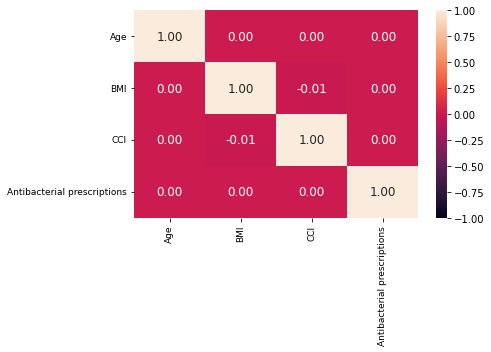

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [39]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                                   'event_lrti_admitted', 'duration_lrti_admitted'
                                    ]]

In [40]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]

# with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

In [41]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

In [71]:
#build cox models
def rf_lr_model_build(infection, infection_type, data):

    ##data prep
    #keep required columns for encoder
    data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bmi_cat', 'antibacterial_brit', infection+'_ab_date']]
    data_req_df = pd.DataFrame(data_req) 
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_req_df[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bmi_cat']]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_req_df[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'bmi_cat']].columns)
    #concat binarised and already binary columns
    data_req_df_cont = data_req_df[['antibacterial_brit', infection+'_ab_date']].reset_index(drop=True)
    data_final = pd.concat([data_req_enc, data_req_df_cont], axis=1)
                        
    #keep needed columns, drop ref categories
    data_col =['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
               'sex_female', #'sex_male', 
               'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
               'flu_vaccine_no', #'flu_vaccine_yes', 
               'region_east', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_yorkshire', 
               'imd_affluent', 'imd_unaffluent', 'imd_unknown', 'imd_very_affluent', 'imd_very_unaffluent', #'imd_medium',
               'ethnicity_non-white', 'ethnicity_unknown', #'ethnicity_white', 
               'smoking_status_ex_smoker', 'smoking_status_smoker', 'smoking_status_unknown', #'smoking_status_never_smoked',
               'season_autumn', 'season_summer', 'season_winter', #'season_spring',
               'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
               'antibacterial_brit'
               ]
    
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_final, test_size=0.25, random_state=42)
    data_dev_y = data_dev[infection+'_ab_date']
    data_dev_x = data_dev[data_col]
    data_val_y = data_val[infection+'_ab_date']
    data_val_x = data_val[data_col]

    ##building rf model
    rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=25)#n_estimators=rf_n_est, max_leaf_nodes=rf_max_lea_nod, max_depth=rf_max_dep) #500,50,25
    rf.fit(data_dev_x, data_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_val_x)[:,1]

    ##building lr model
    lr_uncon = sm.Logit(endog=data_dev_y, exog=data_dev_x)
    lr_uncon = lr_uncon.fit(disp=0)
    #predict probabilities of lr model
    lr_uncon_pred_dev = lr_uncon.predict(data_dev_x)
    lr_uncon_pred_val = lr_uncon.predict(data_val_x)

    #print aurocs
    auroc_rf_dev = roc_auc_score(data_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_val_y, rf_pred_val)
    auroc_lr_uncon_dev = sklearn.metrics.roc_auc_score(data_dev_y, lr_uncon_pred_dev)
    auroc_lr_uncon_val = sklearn.metrics.roc_auc_score(data_val_y, lr_uncon_pred_val)
    print('RF AUROC with development and validation data: %.2f'%(auroc_rf_dev), 'and %.2f' % (auroc_rf_val))
    print('LR AUROC with development and validation data: %.2f'%(auroc_lr_uncon_dev), 'and %.2f' % (auroc_lr_uncon_val))
    
    #plot roc curves
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_val_y, rf_pred_val)
    r_fpr_lr_uncon_dev, r_tpr_lr_uncon_dev, _ = roc_curve(data_dev_y, lr_uncon_pred_dev)
    r_fpr_lr_uncon_val, r_tpr_lr_uncon_val, _ = roc_curve(data_val_y, lr_uncon_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    line_lr_dev, = plt.plot(r_fpr_lr_uncon_dev, r_tpr_lr_uncon_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_uncon_val, r_tpr_lr_uncon_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    
    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of RF and LR models", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'] = rf_prob_pred_dev_groupby_bin[infection+'_ab_date_sum']/rf_prob_pred_dev_groupby_bin[infection+'_ab_date_count']
    
    ##calibration for RF
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'] = rf_prob_pred_val_groupby_bin[infection+'_ab_date_sum']/rf_prob_pred_val_groupby_bin[infection+'_ab_date_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    ##calibration for LR
    lr_uncon_prob_pred_dev = pd.DataFrame(data=lr_uncon_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_uncon_prob_pred_dev['bins'] = pd.qcut(lr_uncon_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_uncon_prob_pred_dev = pd.merge(lr_uncon_prob_pred_dev, data_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_uncon_prob_pred_dev_groupby_bin = lr_uncon_prob_pred_dev.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    lr_uncon_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'] = lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_sum']/lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_count']
    #
    lr_uncon_prob_pred_val = pd.DataFrame(data=lr_uncon_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_uncon_prob_pred_val['bins'] = pd.qcut(lr_uncon_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_uncon_prob_pred_val = pd.merge(lr_uncon_prob_pred_val, data_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_uncon_prob_pred_val_groupby_bin = lr_uncon_prob_pred_val.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    lr_uncon_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    lr_uncon_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'] = lr_uncon_prob_pred_val_groupby_bin[infection+'_ab_date_sum']/lr_uncon_prob_pred_val_groupby_bin[infection+'_ab_date_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_uncon_prob_pred_dev_groupby_bin.pred_mean, lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_uncon_prob_pred_val_groupby_bin.pred_mean, lr_uncon_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_uncon_prob_pred_dev_groupby_bin.pred_mean.max(), lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(lr_uncon_prob_pred_dev_groupby_bin.pred_mean.max(), lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_uncon_prob_pred_dev_groupby_bin.pred_mean.max(), lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(lr_uncon_prob_pred_dev_groupby_bin.pred_mean.max(), lr_uncon_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_dev_x.columns, columns=['rf_feature_importance'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_feature_importance', ascending=False)
    # print("\nRF feature importance:\n", rf_coef)

    #print summary of LR model
    lr_uncon_coef = pd.DataFrame(data=lr_uncon.params, index=data_dev_x.columns, columns=['lr_coef'])
#     lr_uncon_coef = lr_uncon_coef.abs().sort_values('lr_feature_importance', ascending=False)
    lr_uncon_coef = lr_uncon_coef.sort_values('lr_coef', ascending=False)
    # print("\nLR fcoefficients:\n", lr_uncon_coef)

    #concat coefs and save 
    coefs = pd.concat([rf_coef, lr_uncon_coef], axis=1)
    coefs.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_'+infection+'_'+infection_type+'.csv')

### 5-5- incident lrti

RF AUROC with development and validation data: 0.59 and 0.50
LR AUROC with development and validation data: 0.50 and 0.49


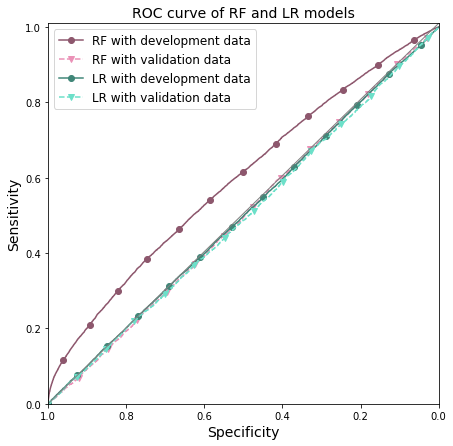

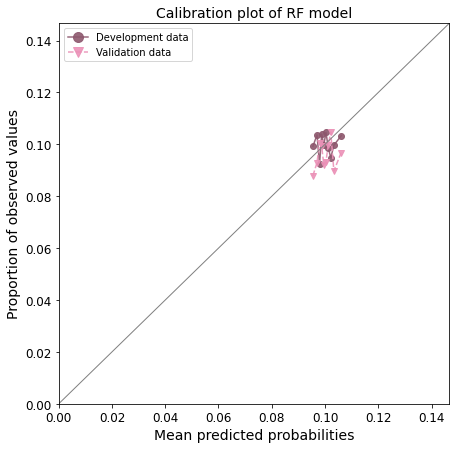

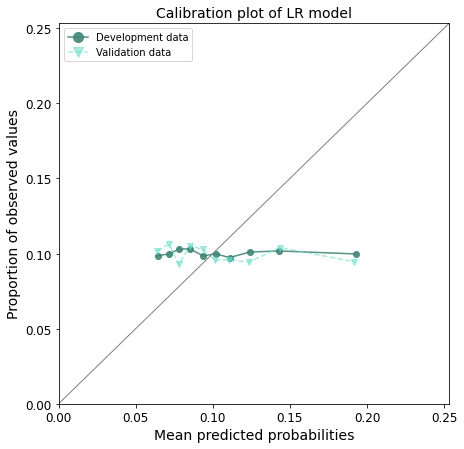

In [72]:
#build rf and lr models
rf_lr_model_build('lrti', 'incdt', data_lrti_incdt)

### 5-6- prevalent lrti

RF AUROC with development and validation data: 0.80 and 0.51
LR AUROC with development and validation data: 0.52 and 0.50


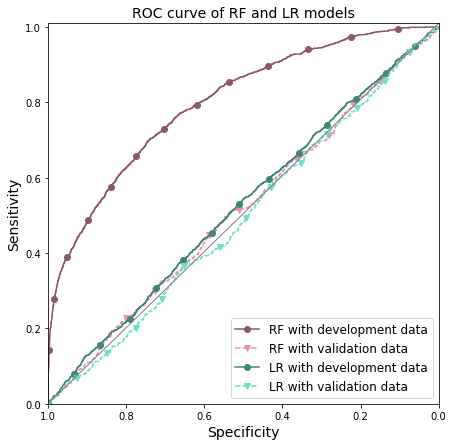

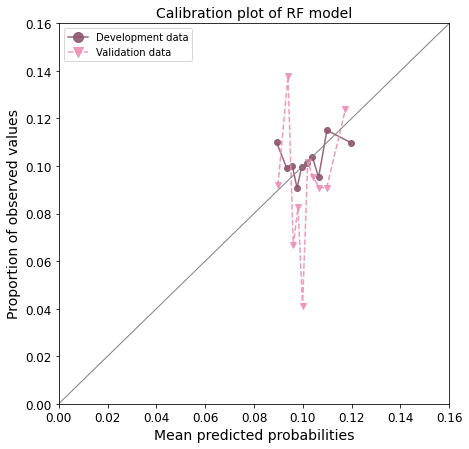

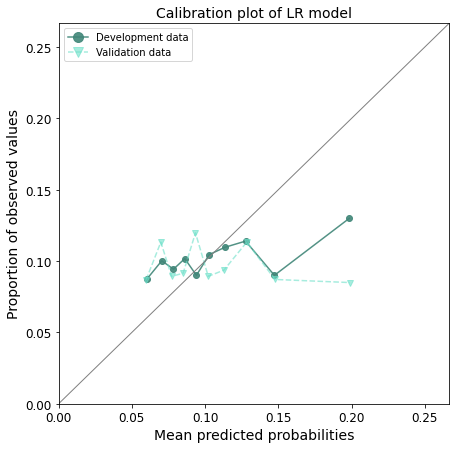

In [73]:
#build rf and lr models
rf_lr_model_build('lrti', 'prevl', data_lrti_prevl)

### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [197]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 124892 total observations, 123979 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 124892
number of events observed = 913
   partial log-likelihood = -10692.91
         time fit was run = 2023-04-12 18:42:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.10            -0.24             0.14                 0.78                 1.15
CCI_cat[T.medium]               -0.07       0.93       0.11            -0.28             0.14                 0.76                 1.15
CCI_cat[T.high]                 -0.21       0.81       0.14            -0.47             0.06                 0.62                 1.07
CCI_cat[T.very_high]             0.04       1.04       0.11            -0.18             0.25                 0.84                 1.29
ab_type_cat[T.Doxycycline]      -0.48       0.62       1.10            -2.63             1.67                 0.07                 5.31
ab_type_cat[T.no]                0.09       1.09       0.45            -0.79             0.97                 0.45                 2.63
ab_type_cat[T.other]             0.10       1.10       0.46            -0.81             1.00                 0.45                 2.71
age_cat[T.25_34]                 0.01       1.01       0.12            -0.23             0.26                 0.80                 1.29
age_cat[T.35_44]                 0.07       1.07       0.12            -0.17             0.31                 0.84                 1.36
age_cat[T.45_54]                 0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
age_cat[T.55_64]                 0.08       1.08       0.12            -0.16             0.32                 0.85                 1.37
age_cat[T.65_74]                -0.09       0.92       0.13            -0.34             0.16                 0.71                 1.18
age_cat[T.75_more]              -0.06       0.94       0.13            -0.30             0.19                 0.74                 1.21
antibacterial_brit               0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
bmi_cat[T.obese]                 0.12       1.12       0.13            -0.14             0.38                 0.87                 1.46
bmi_cat[T.overweight]            0.23       1.26       0.16            -0.08             0.53                 0.92                 1.71
bmi_cat[T.underweight]           0.03       1.03       0.23            -0.42             0.48                 0.66                 1.62
bmi_cat[T.unknown]               0.19       1.21       0.14            -0.08             0.47                 0.92                 1.59
ethnicity[T.unknown]             0.02       1.02       0.11            -0.19             0.24                 0.82                 1.27
ethnicity[T.white]               0.05       1.06       0.10            -0.14             0.24                 0.87                 1.28
flu_vaccine[T.yes]               0.08       1.08       0.11            -0.13             0.29                 0.88                 1.33
imd[T.medium]                   -0.13       0.87       0.11            -0.34             0.08                 0.71                 1.08
imd[T.unaffluent]                0.03       1.03       0.10            -0.17             0.23                 0.84                 1.26
imd[T.unknown]                  -0.34       0.71       0.18            -0.70             0.02                 0.50                 1.02
imd[T.very_affluent]            -0.10       0.90       0.11     

13611


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [198]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13770 total observations, 13671 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13770
number of events observed = 99
   partial log-likelihood = -916.67
         time fit was run = 2023-04-12 18:43:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.38       1.46       0.35            -0.31             1.06                 0.74                 2.88
CCI_cat[T.medium]                0.48       1.62       0.37            -0.24             1.20                 0.79                 3.33
CCI_cat[T.high]                  0.44       1.56       0.44            -0.41             1.30                 0.66                 3.68
CCI_cat[T.very_high]             0.60       1.83       0.37            -0.13             1.33                 0.88                 3.80
ab_type_cat[T.Doxycycline]       0.26       1.30       1.24            -2.16             2.69                 0.11                14.68
ab_type_cat[T.no]               -1.41       0.25       0.72            -2.82             0.00                 0.06                 1.00
ab_type_cat[T.other]            -1.41       0.25       0.79            -2.95             0.14                 0.05                 1.15
age_cat[T.25_34]                -0.12       0.89       0.42            -0.94             0.71                 0.39                 2.02
age_cat[T.35_44]                 0.55       1.74       0.36            -0.16             1.26                 0.85                 3.54
age_cat[T.45_54]                -0.10       0.91       0.42            -0.92             0.72                 0.40                 2.06
age_cat[T.55_64]                 0.46       1.58       0.37            -0.26             1.18                 0.77                 3.26
age_cat[T.65_74]                 0.44       1.56       0.37            -0.29             1.18                 0.75                 3.24
age_cat[T.75_more]              -0.52       0.60       0.48            -1.45             0.42                 0.23                 1.52
antibacterial_brit               0.05       1.05       0.07            -0.09             0.18                 0.91                 1.20
bmi_cat[T.obese]                 1.36       3.89       0.72            -0.06             2.77                 0.95                15.98
bmi_cat[T.overweight]            1.27       3.55       0.78            -0.25             2.79                 0.78                16.21
bmi_cat[T.underweight]           1.22       3.37       0.91            -0.58             3.01                 0.56                20.26
bmi_cat[T.unknown]               1.59       4.92       0.73             0.16             3.02                 1.18                20.55
ethnicity[T.unknown]            -0.44       0.64       0.34            -1.11             0.22                 0.33                 1.25
ethnicity[T.white]              -0.02       0.98       0.27            -0.55             0.52                 0.57                 1.68
flu_vaccine[T.yes]               0.03       1.03       0.33            -0.63             0.68                 0.53                 1.98
imd[T.medium]                   -0.16       0.85       0.38            -0.90             0.59                 0.41                 1.80
imd[T.unaffluent]                0.26       1.30       0.35            -0.42             0.94                 0.66                 2.56
imd[T.unknown]                  -0.27       0.76       0.63            -1.51             0.97                 0.22                 2.64
imd[T.very_affluent]             0.51       1.67       0.33           

13605


### 5-9- stratified by sex
#### 5-9-1- incident males

In [199]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60534 total observations, 60085 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 60534
number of events observed = 449
   partial log-likelihood = -4927.67
         time fit was run = 2023-04-12 18:43:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.14            -0.38             0.16                 0.68                 1.18
CCI_cat[T.medium]               -0.09       0.91       0.15            -0.39             0.21                 0.68                 1.23
CCI_cat[T.high]                 -0.25       0.78       0.20            -0.63             0.13                 0.53                 1.14
CCI_cat[T.very_high]             0.07       1.07       0.15            -0.23             0.37                 0.79                 1.45
age_cat[T.25_34]                -0.05       0.95       0.18            -0.41             0.31                 0.66                 1.36
age_cat[T.35_44]                 0.16       1.18       0.17            -0.18             0.51                 0.84                 1.66
age_cat[T.45_54]                 0.12       1.13       0.18            -0.22             0.47                 0.80                 1.60
age_cat[T.55_64]                 0.05       1.05       0.18            -0.30             0.40                 0.74                 1.50
age_cat[T.65_74]                 0.04       1.04       0.18            -0.31             0.40                 0.73                 1.49
age_cat[T.75_more]               0.03       1.03       0.18            -0.32             0.38                 0.73                 1.47
antibacterial_brit              -0.03       0.97       0.03            -0.10             0.04                 0.91                 1.04
bmi_cat[T.obese]                -0.17       0.84       0.17            -0.50             0.16                 0.60                 1.18
bmi_cat[T.overweight]           -0.06       0.94       0.21            -0.47             0.34                 0.63                 1.41
bmi_cat[T.underweight]          -0.14       0.87       0.30            -0.73             0.45                 0.48                 1.57
bmi_cat[T.unknown]              -0.18       0.84       0.18            -0.54             0.18                 0.59                 1.20
ethnicity[T.unknown]            -0.00       1.00       0.16            -0.32             0.31                 0.73                 1.37
ethnicity[T.white]               0.16       1.17       0.14            -0.12             0.43                 0.89                 1.54
flu_vaccine[T.yes]               0.09       1.10       0.15            -0.21             0.39                 0.81                 1.48
imd[T.medium]                   -0.09       0.91       0.15            -0.39             0.21                 0.68                 1.24
imd[T.unaffluent]               -0.06       0.94       0.15            -0.35             0.24                 0.70                 1.27
imd[T.unknown]                   0.10       1.11       0.22            -0.34             0.54                 0.71                 1.71
imd[T.very_affluent]            -0.13       0.88       0.16            -0.43             0.18                 0.65                 1.19
imd[T.very_unaffluent]          -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.29
lrti_ab_date                    -0.09       0.92       0.16            -0.41             0.24                 0.67                 1.27
region[T.east_midlands]          0.18       1.19       0.20         

12786


#### 5-9-2- incident females

In [200]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 64357 total observations, 63903 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 64357
number of events observed = 454
   partial log-likelihood = -5005.67
         time fit was run = 2023-04-12 18:43:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.08       0.14            -0.20             0.34                 0.82                 1.41
CCI_cat[T.medium]               -0.03       0.97       0.16            -0.33             0.28                 0.72                 1.32
CCI_cat[T.high]                 -0.07       0.94       0.19            -0.44             0.31                 0.64                 1.36
CCI_cat[T.very_high]            -0.03       0.97       0.16            -0.35             0.29                 0.71                 1.34
age_cat[T.25_34]                 0.03       1.04       0.16            -0.28             0.35                 0.76                 1.42
age_cat[T.35_44]                -0.18       0.84       0.17            -0.51             0.16                 0.60                 1.17
age_cat[T.45_54]                -0.38       0.69       0.18            -0.73            -0.02                 0.48                 0.98
age_cat[T.55_64]                -0.05       0.95       0.16            -0.37             0.27                 0.69                 1.31
age_cat[T.65_74]                -0.30       0.74       0.18            -0.65             0.04                 0.52                 1.04
age_cat[T.75_more]              -0.34       0.71       0.18            -0.69             0.01                 0.50                 1.01
antibacterial_brit               0.04       1.04       0.03            -0.03             0.10                 0.97                 1.11
bmi_cat[T.obese]                 0.32       1.38       0.20            -0.07             0.72                 0.93                 2.06
bmi_cat[T.overweight]            0.27       1.31       0.24            -0.20             0.74                 0.82                 2.10
bmi_cat[T.underweight]           0.09       1.09       0.35            -0.59             0.77                 0.55                 2.15
bmi_cat[T.unknown]               0.32       1.38       0.21            -0.09             0.74                 0.91                 2.10
ethnicity[T.unknown]             0.17       1.18       0.16            -0.15             0.48                 0.86                 1.61
ethnicity[T.white]               0.15       1.16       0.14            -0.13             0.43                 0.88                 1.54
flu_vaccine[T.yes]               0.08       1.08       0.15            -0.22             0.37                 0.80                 1.45
imd[T.medium]                   -0.12       0.89       0.15            -0.42             0.17                 0.66                 1.19
imd[T.unaffluent]                0.04       1.04       0.15            -0.25             0.32                 0.78                 1.38
imd[T.unknown]                  -0.59       0.55       0.29            -1.16            -0.03                 0.31                 0.97
imd[T.very_affluent]             0.02       1.02       0.15            -0.26             0.31                 0.77                 1.36
imd[T.very_unaffluent]          -0.25       0.78       0.16            -0.56             0.06                 0.57                 1.06
lrti_ab_date                    -0.11       0.89       0.16            -0.43             0.21                 0.65                 1.23
region[T.east_midlands]         -0.13       0.88       0.20         

12778


#### 5-9-3- prevalent males

In [201]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6676 total observations, 6626 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6676
number of events observed = 50
   partial log-likelihood = -416.06
         time fit was run = 2023-04-12 18:43:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.24       0.44            -0.65             1.08                 0.52                 2.96
CCI_cat[T.medium]                0.46       1.59       0.46            -0.45             1.38                 0.64                 3.96
CCI_cat[T.high]                 -0.58       0.56       0.80            -2.16             0.99                 0.12                 2.70
CCI_cat[T.very_high]             0.07       1.07       0.52            -0.95             1.08                 0.39                 2.96
age_cat[T.25_34]                 0.34       1.41       0.54            -0.72             1.40                 0.49                 4.07
age_cat[T.35_44]                 0.21       1.24       0.56            -0.88             1.31                 0.41                 3.69
age_cat[T.45_54]                 0.50       1.65       0.52            -0.52             1.51                 0.60                 4.55
age_cat[T.55_64]                -0.02       0.98       0.58            -1.15             1.12                 0.32                 3.06
age_cat[T.65_74]                 0.68       1.97       0.51            -0.32             1.68                 0.73                 5.35
age_cat[T.75_more]              -1.05       0.35       0.82            -2.65             0.55                 0.07                 1.74
antibacterial_brit               0.03       1.03       0.10            -0.17             0.22                 0.85                 1.25
bmi_cat[T.obese]                 0.25       1.29       0.61            -0.95             1.45                 0.39                 4.28
bmi_cat[T.overweight]            0.15       1.17       0.73            -1.28             1.59                 0.28                 4.90
bmi_cat[T.underweight]         -15.48       0.00    2133.59         -4197.24          4166.28                 0.00                  inf
bmi_cat[T.unknown]               0.61       1.84       0.63            -0.62             1.84                 0.54                 6.30
ethnicity[T.unknown]            -0.21       0.81       0.53            -1.25             0.83                 0.29                 2.29
ethnicity[T.white]               0.39       1.48       0.44            -0.48             1.26                 0.62                 3.52
flu_vaccine[T.yes]              -0.57       0.57       0.60            -1.74             0.61                 0.18                 1.83
imd[T.medium]                   -0.36       0.70       0.59            -1.51             0.79                 0.22                 2.21
imd[T.unaffluent]                0.34       1.40       0.50            -0.64             1.31                 0.53                 3.69
imd[T.unknown]                   0.08       1.08       0.80            -1.50             1.65                 0.22                 5.21
imd[T.very_affluent]             0.34       1.41       0.49            -0.63             1.31                 0.53                 3.70
imd[T.very_unaffluent]           0.77       2.16       0.45            -0.12             1.66                 0.89                 5.27
lrti_ab_date                     0.55       1.74       0.39            -0.21             1.32                 0.81                 3.73
region[T.east_midlands]         -0.04       0.96       0.71            -1

12770


#### 5-9-4- prevalent females

In [202]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7094 total observations, 7043 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 7094
number of events observed = 51
   partial log-likelihood = -432.39
         time fit was run = 2023-04-12 18:43:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.48            -0.71             1.17                 0.49                 3.23
CCI_cat[T.medium]                0.31       1.37       0.51            -0.68             1.31                 0.50                 3.72
CCI_cat[T.high]                  0.01       1.01       0.65            -1.26             1.28                 0.28                 3.59
CCI_cat[T.very_high]             0.81       2.24       0.49            -0.16             1.77                 0.85                 5.87
age_cat[T.25_34]                 0.78       2.17       0.69            -0.58             2.13                 0.56                 8.42
age_cat[T.35_44]                 1.18       3.25       0.66            -0.11             2.47                 0.89                11.85
age_cat[T.45_54]                 0.88       2.41       0.69            -0.48             2.23                 0.62                 9.34
age_cat[T.55_64]                 0.97       2.64       0.68            -0.36             2.30                 0.70                 9.96
age_cat[T.65_74]                 1.19       3.29       0.66            -0.10             2.48                 0.90                12.00
age_cat[T.75_more]               0.69       1.99       0.71            -0.70             2.08                 0.50                 8.00
antibacterial_brit              -0.01       0.99       0.10            -0.21             0.18                 0.81                 1.20
bmi_cat[T.obese]                 0.67       1.95       0.73            -0.77             2.10                 0.46                 8.20
bmi_cat[T.overweight]            0.31       1.37       0.87            -1.39             2.02                 0.25                 7.52
bmi_cat[T.underweight]           0.75       2.13       1.00            -1.22             2.72                 0.30                15.22
bmi_cat[T.unknown]               0.74       2.09       0.75            -0.74             2.22                 0.48                 9.18
ethnicity[T.unknown]            -0.11       0.90       0.46            -1.00             0.79                 0.37                 2.21
ethnicity[T.white]              -0.04       0.96       0.40            -0.82             0.74                 0.44                 2.10
flu_vaccine[T.yes]              -0.00       1.00       0.47            -0.93             0.92                 0.40                 2.52
imd[T.medium]                    0.42       1.53       0.53            -0.61             1.46                 0.54                 4.30
imd[T.unaffluent]                0.42       1.52       0.53            -0.62             1.46                 0.54                 4.29
imd[T.unknown]                  -0.49       0.61       1.08            -2.61             1.63                 0.07                 5.12
imd[T.very_affluent]             0.86       2.37       0.50            -0.11             1.83                 0.90                 6.26
imd[T.very_unaffluent]           0.81       2.26       0.50            -0.16             1.78                 0.85                 5.96
lrti_ab_date                     0.24       1.27       0.44            -0.61             1.09                 0.54                 2.99
region[T.east_midlands]         -0.68       0.51       0.87            -2

12755


### 5-10- stratified by age category
#### 5-10-1- incident

In [203]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17822 total observations, 17695 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17822
number of events observed = 127
   partial log-likelihood = -1231.93
         time fit was run = 2023-04-12 18:43:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.45       0.64       0.25            -0.93             0.04                 0.39                 1.04
CCI_cat[T.medium]               -0.51       0.60       0.29            -1.07             0.06                 0.34                 1.06
CCI_cat[T.high]                 -0.04       0.97       0.31            -0.64             0.57                 0.53                 1.77
CCI_cat[T.very_high]            -0.33       0.72       0.29            -0.89             0.23                 0.41                 1.26
antibacterial_brit               0.02       1.02       0.06            -0.11             0.14                 0.90                 1.15
bmi_cat[T.obese]                 0.65       1.92       0.43            -0.18             1.49                 0.84                 4.42
bmi_cat[T.overweight]            0.59       1.81       0.48            -0.35             1.54                 0.70                 4.67
bmi_cat[T.underweight]           0.91       2.48       0.58            -0.23             2.04                 0.80                 7.68
bmi_cat[T.unknown]               0.38       1.46       0.45            -0.51             1.26                 0.60                 3.53
ethnicity[T.unknown]             0.01       1.01       0.28            -0.55             0.56                 0.58                 1.75
ethnicity[T.white]              -0.08       0.92       0.25            -0.58             0.41                 0.56                 1.51
flu_vaccine[T.yes]               0.09       1.10       0.29            -0.48             0.67                 0.62                 1.95
imd[T.medium]                   -0.17       0.85       0.28            -0.72             0.39                 0.49                 1.47
imd[T.unaffluent]               -0.47       0.63       0.30            -1.06             0.13                 0.35                 1.13
imd[T.unknown]                  -0.24       0.79       0.45            -1.12             0.64                 0.33                 1.90
imd[T.very_affluent]            -0.16       0.85       0.28            -0.71             0.38                 0.49                 1.47
imd[T.very_unaffluent]          -0.04       0.96       0.27            -0.56             0.49                 0.57                 1.63
lrti_ab_date                     0.05       1.06       0.29            -0.52             0.63                 0.59                 1.87
region[T.east_midlands]         -0.36       0.70       0.38            -1.10             0.38                 0.33                 1.46
region[T.london]                -0.04       0.96       0.30            -0.62             0.54                 0.54                 1.72
region[T.north_east]            -0.50       0.61       0.40            -1.28             0.28                 0.28                 1.32
region[T.north_west]            -0.39       0.68       0.39            -1.15             0.37                 0.32                 1.45
region[T.south_east]            -0.50       0.61       0.40            -1.28             0.29                 0.28                 1.33
region[T.south_west]            -0.36       0.70       0.38            -1.10             0.38                 0.33                 1.46
region[T.west_midlands]         -0.29       0.75       0.37         

11410


In [204]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18044 total observations, 17913 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 18044
number of events observed = 131
   partial log-likelihood = -1262.81
         time fit was run = 2023-04-12 18:43:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.32       0.73       0.23            -0.77             0.13                 0.46                 1.14
CCI_cat[T.medium]               -0.81       0.45       0.30            -1.39            -0.23                 0.25                 0.80
CCI_cat[T.high]                 -0.78       0.46       0.38            -1.52            -0.04                 0.22                 0.96
CCI_cat[T.very_high]            -0.24       0.79       0.27            -0.77             0.29                 0.46                 1.33
antibacterial_brit              -0.07       0.94       0.06            -0.19             0.06                 0.83                 1.06
bmi_cat[T.obese]                -0.30       0.74       0.30            -0.90             0.29                 0.41                 1.34
bmi_cat[T.overweight]           -0.10       0.91       0.36            -0.81             0.62                 0.44                 1.86
bmi_cat[T.underweight]          -0.64       0.52       0.64            -1.90             0.61                 0.15                 1.84
bmi_cat[T.unknown]              -0.37       0.69       0.33            -1.02             0.28                 0.36                 1.32
ethnicity[T.unknown]             0.25       1.29       0.29            -0.31             0.81                 0.73                 2.26
ethnicity[T.white]               0.05       1.05       0.26            -0.47             0.57                 0.63                 1.76
flu_vaccine[T.yes]              -0.91       0.40       0.42            -1.73            -0.09                 0.18                 0.92
imd[T.medium]                   -0.23       0.80       0.29            -0.79             0.33                 0.45                 1.39
imd[T.unaffluent]                0.01       1.01       0.27            -0.52             0.53                 0.59                 1.70
imd[T.unknown]                  -0.63       0.53       0.54            -1.68             0.42                 0.19                 1.52
imd[T.very_affluent]            -0.32       0.72       0.29            -0.90             0.25                 0.41                 1.29
imd[T.very_unaffluent]           0.03       1.03       0.27            -0.49             0.55                 0.61                 1.73
lrti_ab_date                     0.26       1.30       0.26            -0.25             0.77                 0.78                 2.17
region[T.east_midlands]         -0.14       0.87       0.35            -0.83             0.55                 0.44                 1.73
region[T.london]                -0.13       0.88       0.30            -0.71             0.46                 0.49                 1.58
region[T.north_east]            -0.52       0.59       0.38            -1.27             0.23                 0.28                 1.26
region[T.north_west]            -0.24       0.79       0.36            -0.94             0.46                 0.39                 1.59
region[T.south_east]            -1.27       0.28       0.51            -2.27            -0.28                 0.10                 0.75
region[T.south_west]            -0.18       0.83       0.36            -0.88             0.52                 0.41                 1.68
region[T.west_midlands]         -0.10       0.90       0.34         

11416


In [205]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17697 total observations, 17568 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17697
number of events observed = 129
   partial log-likelihood = -1242.08
         time fit was run = 2023-04-12 18:43:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.53       1.70       0.31            -0.09             1.14                 0.92                 3.14
CCI_cat[T.medium]                0.81       2.24       0.32             0.17             1.44                 1.19                 4.21
CCI_cat[T.high]                  0.07       1.07       0.43            -0.78             0.92                 0.46                 2.50
CCI_cat[T.very_high]             0.56       1.74       0.35            -0.12             1.24                 0.88                 3.45
antibacterial_brit               0.05       1.05       0.06            -0.07             0.17                 0.93                 1.19
bmi_cat[T.obese]                 0.05       1.05       0.34            -0.62             0.71                 0.54                 2.04
bmi_cat[T.overweight]           -0.23       0.80       0.43            -1.07             0.61                 0.34                 1.84
bmi_cat[T.underweight]          -0.76       0.47       0.78            -2.28             0.76                 0.10                 2.14
bmi_cat[T.unknown]               0.16       1.17       0.36            -0.54             0.86                 0.58                 2.36
ethnicity[T.unknown]             0.56       1.76       0.39            -0.19             1.32                 0.83                 3.74
ethnicity[T.white]               0.94       2.55       0.35             0.25             1.62                 1.29                 5.06
flu_vaccine[T.yes]              -0.14       0.87       0.32            -0.76             0.48                 0.47                 1.62
imd[T.medium]                   -0.03       0.97       0.29            -0.60             0.53                 0.55                 1.70
imd[T.unaffluent]                0.17       1.19       0.27            -0.36             0.70                 0.70                 2.02
imd[T.unknown]                  -0.29       0.75       0.49            -1.25             0.68                 0.29                 1.97
imd[T.very_affluent]            -0.15       0.86       0.30            -0.73             0.43                 0.48                 1.54
imd[T.very_unaffluent]          -0.17       0.85       0.30            -0.75             0.41                 0.47                 1.51
lrti_ab_date                     0.08       1.09       0.28            -0.47             0.64                 0.62                 1.89
region[T.east_midlands]          0.34       1.41       0.33            -0.31             0.99                 0.73                 2.70
region[T.london]                -0.08       0.93       0.31            -0.69             0.54                 0.50                 1.71
region[T.north_east]            -0.43       0.65       0.39            -1.20             0.34                 0.30                 1.41
region[T.north_west]            -0.69       0.50       0.43            -1.54             0.16                 0.21                 1.17
region[T.south_east]            -0.31       0.74       0.39            -1.07             0.46                 0.34                 1.59
region[T.south_west]            -0.53       0.59       0.42            -1.34             0.29                 0.26                 1.34
region[T.west_midlands]         -0.32       0.72       0.38         

11398


In [206]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17734 total observations, 17605 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17734
number of events observed = 129
   partial log-likelihood = -1241.43
         time fit was run = 2023-04-12 18:43:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.40       1.50       0.31            -0.20             1.00                 0.82                 2.72
CCI_cat[T.medium]                0.36       1.44       0.33            -0.29             1.01                 0.75                 2.74
CCI_cat[T.high]                  0.45       1.58       0.38            -0.29             1.20                 0.75                 3.31
CCI_cat[T.very_high]             0.66       1.94       0.33             0.02             1.31                 1.02                 3.69
antibacterial_brit               0.06       1.06       0.06            -0.06             0.18                 0.94                 1.19
bmi_cat[T.obese]                 0.17       1.19       0.35            -0.52             0.87                 0.59                 2.38
bmi_cat[T.overweight]            0.38       1.47       0.41            -0.41             1.18                 0.66                 3.25
bmi_cat[T.underweight]           0.47       1.60       0.53            -0.57             1.50                 0.57                 4.49
bmi_cat[T.unknown]              -0.21       0.81       0.39            -0.98             0.56                 0.38                 1.75
ethnicity[T.unknown]            -0.29       0.75       0.28            -0.84             0.25                 0.43                 1.29
ethnicity[T.white]              -0.17       0.84       0.24            -0.64             0.30                 0.53                 1.34
flu_vaccine[T.yes]              -0.09       0.91       0.30            -0.68             0.51                 0.50                 1.66
imd[T.medium]                    0.20       1.23       0.30            -0.38             0.79                 0.69                 2.19
imd[T.unaffluent]                0.29       1.34       0.29            -0.27             0.86                 0.76                 2.36
imd[T.unknown]                  -0.37       0.69       0.55            -1.44             0.70                 0.24                 2.01
imd[T.very_affluent]             0.44       1.55       0.28            -0.12             0.99                 0.89                 2.69
imd[T.very_unaffluent]          -0.05       0.95       0.31            -0.66             0.57                 0.52                 1.76
lrti_ab_date                    -0.68       0.51       0.39            -1.44             0.08                 0.24                 1.08
region[T.east_midlands]         -0.40       0.67       0.37            -1.12             0.32                 0.33                 1.38
region[T.london]                -0.32       0.73       0.30            -0.90             0.27                 0.41                 1.31
region[T.north_east]            -0.53       0.59       0.38            -1.28             0.21                 0.28                 1.23
region[T.north_west]            -0.24       0.79       0.35            -0.92             0.44                 0.40                 1.55
region[T.south_east]            -0.31       0.73       0.36            -1.02             0.39                 0.36                 1.48
region[T.south_west]            -0.01       0.99       0.33            -0.66             0.65                 0.52                 1.92
region[T.west_midlands]         -1.30       0.27       0.50         

11404


In [207]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18052 total observations, 17924 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 18052
number of events observed = 128
   partial log-likelihood = -1242.53
         time fit was run = 2023-04-12 18:43:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.20       1.22       0.29            -0.36             0.76                 0.70                 2.14
CCI_cat[T.medium]                0.46       1.58       0.30            -0.13             1.04                 0.88                 2.83
CCI_cat[T.high]                  0.23       1.26       0.37            -0.49             0.95                 0.61                 2.59
CCI_cat[T.very_high]             0.12       1.13       0.33            -0.52             0.77                 0.59                 2.16
antibacterial_brit              -0.10       0.90       0.07            -0.23             0.03                 0.79                 1.03
bmi_cat[T.obese]                 0.32       1.38       0.40            -0.46             1.10                 0.63                 3.01
bmi_cat[T.overweight]            0.46       1.59       0.45            -0.43             1.35                 0.65                 3.86
bmi_cat[T.underweight]          -0.49       0.61       0.80            -2.07             1.08                 0.13                 2.94
bmi_cat[T.unknown]               0.49       1.63       0.41            -0.32             1.30                 0.73                 3.66
ethnicity[T.unknown]            -0.02       0.98       0.30            -0.61             0.56                 0.54                 1.75
ethnicity[T.white]               0.15       1.17       0.26            -0.36             0.67                 0.70                 1.95
flu_vaccine[T.yes]               0.10       1.10       0.28            -0.46             0.65                 0.63                 1.92
imd[T.medium]                    0.10       1.11       0.28            -0.44             0.64                 0.65                 1.90
imd[T.unaffluent]                0.15       1.16       0.28            -0.39             0.69                 0.67                 1.99
imd[T.unknown]                  -0.56       0.57       0.54            -1.61             0.50                 0.20                 1.65
imd[T.very_affluent]            -0.12       0.88       0.30            -0.71             0.46                 0.49                 1.58
imd[T.very_unaffluent]          -0.09       0.91       0.29            -0.67             0.48                 0.51                 1.62
lrti_ab_date                    -0.50       0.60       0.37            -1.22             0.21                 0.30                 1.24
region[T.east_midlands]         -0.67       0.51       0.39            -1.43             0.10                 0.24                 1.10
region[T.london]                -0.67       0.51       0.32            -1.30            -0.04                 0.27                 0.96
region[T.north_east]            -0.45       0.64       0.36            -1.15             0.26                 0.32                 1.30
region[T.north_west]            -0.21       0.81       0.34            -0.88             0.45                 0.41                 1.57
region[T.south_east]            -0.65       0.52       0.39            -1.42             0.11                 0.24                 1.12
region[T.south_west]            -0.55       0.57       0.38            -1.30             0.19                 0.27                 1.21
region[T.west_midlands]         -0.39       0.67       0.36         

11403


In [208]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17635 total observations, 17522 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17635
number of events observed = 113
   partial log-likelihood = -1084.30
         time fit was run = 2023-04-12 18:43:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.28            -0.53             0.58                 0.59                 1.79
CCI_cat[T.medium]                0.26       1.30       0.30            -0.32             0.85                 0.72                 2.33
CCI_cat[T.high]                 -0.80       0.45       0.51            -1.79             0.19                 0.17                 1.21
CCI_cat[T.very_high]             0.05       1.05       0.33            -0.60             0.69                 0.55                 2.00
antibacterial_brit               0.10       1.11       0.06            -0.02             0.23                 0.98                 1.26
bmi_cat[T.obese]                 0.38       1.46       0.47            -0.55             1.30                 0.58                 3.66
bmi_cat[T.overweight]            1.09       2.97       0.50             0.11             2.07                 1.12                 7.90
bmi_cat[T.underweight]           0.07       1.07       0.84            -1.57             1.71                 0.21                 5.52
bmi_cat[T.unknown]               0.83       2.30       0.48            -0.10             1.77                 0.90                 5.86
ethnicity[T.unknown]            -0.23       0.79       0.30            -0.81             0.35                 0.44                 1.41
ethnicity[T.white]              -0.17       0.85       0.26            -0.67             0.33                 0.51                 1.40
flu_vaccine[T.yes]               0.18       1.20       0.30            -0.40             0.76                 0.67                 2.14
imd[T.medium]                    0.07       1.07       0.35            -0.61             0.75                 0.54                 2.12
imd[T.unaffluent]                0.61       1.85       0.31             0.01             1.21                 1.01                 3.37
imd[T.unknown]                   0.67       1.96       0.43            -0.18             1.53                 0.84                 4.60
imd[T.very_affluent]             0.41       1.50       0.32            -0.22             1.03                 0.80                 2.81
imd[T.very_unaffluent]          -0.12       0.88       0.36            -0.83             0.58                 0.44                 1.79
lrti_ab_date                    -0.31       0.73       0.35            -0.99             0.37                 0.37                 1.45
region[T.east_midlands]          0.00       1.00       0.42            -0.82             0.82                 0.44                 2.27
region[T.london]                -0.07       0.93       0.37            -0.79             0.65                 0.46                 1.91
region[T.north_east]             0.39       1.47       0.38            -0.35             1.13                 0.70                 3.09
region[T.north_west]             0.08       1.09       0.41            -0.72             0.88                 0.49                 2.42
region[T.south_east]             0.09       1.10       0.41            -0.71             0.89                 0.49                 2.44
region[T.south_west]            -0.17       0.84       0.44            -1.04             0.69                 0.35                 2.00
region[T.west_midlands]          0.09       1.09       0.41         

11384


In [209]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17906 total observations, 17781 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17906
number of events observed = 125
   partial log-likelihood = -1209.40
         time fit was run = 2023-04-12 18:43:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.27            -0.44             0.62                 0.65                 1.86
CCI_cat[T.medium]               -0.08       0.92       0.31            -0.69             0.52                 0.50                 1.69
CCI_cat[T.high]                  0.05       1.05       0.36            -0.65             0.75                 0.52                 2.12
CCI_cat[T.very_high]             0.28       1.33       0.30            -0.30             0.87                 0.74                 2.38
antibacterial_brit              -0.03       0.97       0.06            -0.15             0.10                 0.86                 1.10
bmi_cat[T.obese]                 0.30       1.35       0.40            -0.48             1.09                 0.62                 2.96
bmi_cat[T.overweight]           -0.12       0.89       0.50            -1.11             0.87                 0.33                 2.39
bmi_cat[T.underweight]           0.11       1.11       0.69            -1.25             1.46                 0.29                 4.31
bmi_cat[T.unknown]               0.65       1.91       0.41            -0.15             1.45                 0.86                 4.25
ethnicity[T.unknown]            -0.01       0.99       0.30            -0.61             0.58                 0.55                 1.79
ethnicity[T.white]               0.11       1.12       0.26            -0.40             0.62                 0.67                 1.86
flu_vaccine[T.yes]               0.19       1.21       0.28            -0.36             0.75                 0.70                 2.12
imd[T.medium]                   -0.14       0.87       0.29            -0.70             0.43                 0.49                 1.54
imd[T.unaffluent]                0.01       1.01       0.28            -0.53             0.56                 0.59                 1.75
imd[T.unknown]                   0.07       1.07       0.43            -0.76             0.91                 0.47                 2.48
imd[T.very_affluent]            -0.30       0.74       0.31            -0.90             0.30                 0.41                 1.35
imd[T.very_unaffluent]           0.00       1.00       0.28            -0.54             0.55                 0.58                 1.73
lrti_ab_date                     0.11       1.12       0.28            -0.45             0.67                 0.64                 1.95
region[T.east_midlands]          0.08       1.09       0.37            -0.65             0.81                 0.52                 2.25
region[T.london]                -0.22       0.80       0.34            -0.89             0.45                 0.41                 1.57
region[T.north_east]            -0.37       0.69       0.41            -1.19             0.44                 0.31                 1.55
region[T.north_west]            -1.01       0.36       0.52            -2.04             0.01                 0.13                 1.01
region[T.south_east]            -0.31       0.74       0.41            -1.12             0.51                 0.33                 1.66
region[T.south_west]             0.08       1.08       0.37            -0.64             0.79                 0.53                 2.21
region[T.west_midlands]          0.04       1.04       0.37         

11399


#### 5-10-2- prevalent

In [210]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1959 total observations, 1951 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1959
number of events observed = 8
   partial log-likelihood = -40.43
         time fit was run = 2023-04-12 18:43:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.01       0.36       1.38            -3.71             1.68                 0.02                 5.37
CCI_cat[T.medium]                1.17       3.23       1.13            -1.04             3.39                 0.35                29.54
CCI_cat[T.high]                -18.48       0.00    9499.20        -18636.58         18599.61                 0.00                  inf
CCI_cat[T.very_high]             0.34       1.41       1.20            -2.00             2.68                 0.13                14.64
antibacterial_brit              -0.25       0.78       0.34            -0.91             0.42                 0.40                 1.52
bmi_cat[T.obese]                21.17   1.57e+09   42955.76        -84170.58         84212.92                 0.00                  inf
bmi_cat[T.overweight]           20.86   1.14e+09   42955.76        -84170.89         84212.61                 0.00                  inf
bmi_cat[T.underweight]           2.21       9.10   58699.31       -115046.33        115050.74                 0.00                  inf
bmi_cat[T.unknown]              19.88   4.32e+08   42955.76        -84171.87         84211.63                 0.00                  inf
ethnicity[T.unknown]            -0.09       0.92       1.60            -3.22             3.04                 0.04                20.99
ethnicity[T.white]               1.08       2.93       1.26            -1.39             3.54                 0.25                34.49
flu_vaccine[T.yes]             -18.14       0.00    8864.52        -17392.28         17356.00                 0.00                  inf
imd[T.medium]                  -21.00       0.00   45228.49        -88667.20         88625.21                 0.00                  inf
imd[T.unaffluent]                0.63       1.88       1.52            -2.35             3.61                 0.10                36.93
imd[T.unknown]                   2.68      14.60       1.58            -0.41             5.77                 0.66               321.68
imd[T.very_affluent]             1.01       2.74       1.56            -2.04             4.06                 0.13                57.97
imd[T.very_unaffluent]           1.62       5.03       1.33            -1.00             4.23                 0.37                68.64
lrti_ab_date                     0.75       2.12       1.23            -1.66             3.16                 0.19                23.58
region[T.east_midlands]         -0.25       0.78       1.60            -3.39             2.89                 0.03                17.96
region[T.london]                -0.79       0.45       1.54            -3.81             2.24                 0.02                 9.35
region[T.north_east]             1.19       3.28       1.39            -1.53             3.91                 0.22                49.93
region[T.north_west]            -0.30       0.74       1.62            -3.48             2.89                 0.03                17.92
region[T.south_east]           -20.09       0.00   21135.44        -41444.79         41404.62                 0.00                  inf
region[T.south_west]           -16.79       0.00    4379.30         -8600.07          8566.48                 0.00                  inf
region[T.west_midlands]         -0.02       0.98       1.63            -3.2

11550


In [211]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2002 total observations, 1989 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2002
number of events observed = 13
   partial log-likelihood = -82.32
         time fit was run = 2023-04-12 18:43:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.48       0.23       0.77            -2.99             0.03                 0.05                 1.03
CCI_cat[T.medium]               -0.57       0.57       0.71            -1.97             0.83                 0.14                 2.29
CCI_cat[T.high]                -18.65       0.00    6347.09        -12458.72         12421.41                 0.00                  inf
CCI_cat[T.very_high]            -1.77       0.17       1.12            -3.96             0.42                 0.02                 1.52
antibacterial_brit               0.29       1.34       0.18            -0.06             0.65                 0.94                 1.92
bmi_cat[T.obese]                -0.75       0.47       0.88            -2.47             0.96                 0.08                 2.62
bmi_cat[T.overweight]          -18.40       0.00    5055.41         -9926.83          9890.02                 0.00                  inf
bmi_cat[T.underweight]         -18.19       0.00   10612.25        -20817.82         20781.43                 0.00                  inf
bmi_cat[T.unknown]              -0.64       0.53       0.92            -2.45             1.18                 0.09                 3.24
ethnicity[T.unknown]            -0.74       0.48       0.97            -2.64             1.15                 0.07                 3.17
ethnicity[T.white]              -0.34       0.71       0.74            -1.80             1.12                 0.17                 3.05
flu_vaccine[T.yes]             -17.71       0.00    4952.78         -9724.98          9689.56                 0.00                  inf
imd[T.medium]                    0.52       1.69       1.25            -1.93             2.98                 0.14                19.66
imd[T.unaffluent]                0.41       1.51       1.24            -2.02             2.85                 0.13                17.26
imd[T.unknown]                 -16.97       0.00    7461.35        -14640.95         14607.02                 0.00                  inf
imd[T.very_affluent]             1.22       3.38       1.14            -1.02             3.46                 0.36                31.66
imd[T.very_unaffluent]           1.33       3.79       1.14            -0.91             3.57                 0.40                35.50
lrti_ab_date                     1.12       3.05       0.70            -0.26             2.49                 0.77                12.04
region[T.east_midlands]          0.02       1.02       1.43            -2.79             2.83                 0.06                16.88
region[T.london]                -0.08       0.92       1.24            -2.51             2.35                 0.08                10.50
region[T.north_east]             0.89       2.43       1.19            -1.44             3.22                 0.24                24.91
region[T.north_west]             0.13       1.14       1.43            -2.66             2.92                 0.07                18.62
region[T.south_east]           -17.30       0.00    5576.36        -10946.76         10912.16                 0.00                  inf
region[T.south_west]             0.47       1.60       1.24            -1.95             2.90                 0.14                18.15
region[T.west_midlands]          0.26       1.29       1.26            -2.

11515


In [212]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1992 total observations, 1972 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1992
number of events observed = 20
   partial log-likelihood = -136.67
         time fit was run = 2023-04-12 18:43:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.25       3.47       1.07            -0.86             3.35                 0.42                28.42
CCI_cat[T.medium]                1.15       3.16       1.11            -1.02             3.32                 0.36                27.68
CCI_cat[T.high]                  1.15       3.16       1.23            -1.27             3.57                 0.28                35.44
CCI_cat[T.very_high]             1.22       3.40       1.14            -1.00             3.45                 0.37                31.56
antibacterial_brit               0.12       1.13       0.16            -0.20             0.43                 0.82                 1.54
bmi_cat[T.obese]                16.49   1.45e+07    3791.79         -7415.27          7448.26                 0.00                  inf
bmi_cat[T.overweight]           16.35   1.26e+07    3791.79         -7415.42          7448.11                 0.00                  inf
bmi_cat[T.underweight]          16.95   2.30e+07    3791.79         -7414.81          7448.72                 0.00                  inf
bmi_cat[T.unknown]              16.78   1.95e+07    3791.79         -7414.98          7448.55                 0.00                  inf
ethnicity[T.unknown]             1.12       3.08       1.09            -1.01             3.26                 0.36                25.99
ethnicity[T.white]               1.15       3.17       1.04            -0.89             3.20                 0.41                24.51
flu_vaccine[T.yes]               0.36       1.43       0.64            -0.90             1.62                 0.41                 5.06
imd[T.medium]                    0.41       1.50       0.93            -1.41             2.22                 0.24                 9.19
imd[T.unaffluent]                0.83       2.30       0.85            -0.83             2.50                 0.44                12.18
imd[T.unknown]                 -15.72       0.00    3783.58         -7431.40          7399.96                 0.00                  inf
imd[T.very_affluent]             0.91       2.48       0.85            -0.76             2.58                 0.47                13.16
imd[T.very_unaffluent]           0.89       2.44       0.85            -0.77             2.56                 0.46                12.88
lrti_ab_date                     0.25       1.28       0.77            -1.25             1.75                 0.29                 5.75
region[T.east_midlands]          0.80       2.23       1.24            -1.62             3.22                 0.20                25.09
region[T.london]                 0.60       1.82       1.16            -1.68             2.87                 0.19                17.67
region[T.north_east]             0.02       1.02       1.43            -2.77             2.82                 0.06                16.74
region[T.north_west]             1.51       4.50       1.13            -0.71             3.72                 0.49                41.36
region[T.south_east]             0.16       1.17       1.42            -2.63             2.94                 0.07                18.96
region[T.south_west]             0.03       1.03       1.42            -2.76             2.82                 0.06                16.77
region[T.west_midlands]          0.11       1.12       1.43            -2

11456


In [213]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1977 total observations, 1963 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1977
number of events observed = 14
   partial log-likelihood = -76.04
         time fit was run = 2023-04-12 18:43:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.91       0.40       1.04            -2.94             1.13                 0.05                 3.09
CCI_cat[T.medium]                1.65       5.22       0.83             0.02             3.29                 1.02                26.74
CCI_cat[T.high]                -18.47       0.00    7865.98        -15435.51         15398.57                 0.00                  inf
CCI_cat[T.very_high]            -0.83       0.44       1.29            -3.36             1.70                 0.03                 5.50
antibacterial_brit              -0.42       0.66       0.26            -0.92             0.08                 0.40                 1.09
bmi_cat[T.obese]                17.86   5.73e+07    7271.58        -14234.18         14269.91                 0.00                  inf
bmi_cat[T.overweight]            0.14       1.15    9807.28        -19221.78         19222.05                 0.00                  inf
bmi_cat[T.underweight]          19.62   3.31e+08    7271.58        -14232.43         14271.66                 0.00                  inf
bmi_cat[T.unknown]              19.20   2.18e+08    7271.58        -14232.85         14271.24                 0.00                  inf
ethnicity[T.unknown]             0.30       1.35       0.90            -1.46             2.06                 0.23                 7.84
ethnicity[T.white]              -0.30       0.74       0.90            -2.07             1.47                 0.13                 4.33
flu_vaccine[T.yes]               1.36       3.91       0.73            -0.06             2.79                 0.94                16.25
imd[T.medium]                  -17.74       0.00    4961.37         -9741.84          9706.36                 0.00                  inf
imd[T.unaffluent]                1.04       2.83       1.23            -1.36             3.45                 0.26                31.37
imd[T.unknown]                 -17.75       0.00   11339.15        -22242.07         22206.57                 0.00                  inf
imd[T.very_affluent]             0.99       2.70       1.29            -1.54             3.53                 0.21                34.09
imd[T.very_unaffluent]           2.58      13.13       1.15             0.33             4.82                 1.39               124.43
lrti_ab_date                     0.23       1.26       0.84            -1.41             1.87                 0.24                 6.48
region[T.east_midlands]          0.54       1.71       1.27            -1.95             3.02                 0.14                20.51
region[T.london]                -1.00       0.37       1.48            -3.91             1.90                 0.02                 6.72
region[T.north_east]             0.72       2.05       1.27            -1.78             3.21                 0.17                24.88
region[T.north_west]             1.09       2.99       1.28            -1.42             3.60                 0.24                36.72
region[T.south_east]             0.13       1.14       1.44            -2.69             2.96                 0.07                19.24
region[T.south_west]             0.45       1.57       1.46            -2.40             3.31                 0.09                27.33
region[T.west_midlands]         -0.52       0.60       1.50            -3.

11520


In [214]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1986 total observations, 1970 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1986
number of events observed = 16
   partial log-likelihood = -102.75
         time fit was run = 2023-04-12 18:43:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.86            -1.52             1.85                 0.22                 6.36
CCI_cat[T.medium]                0.38       1.46       0.94            -1.46             2.22                 0.23                 9.21
CCI_cat[T.high]                  0.99       2.70       0.94            -0.84             2.83                 0.43                16.95
CCI_cat[T.very_high]             0.44       1.56       0.94            -1.40             2.29                 0.25                 9.84
antibacterial_brit               0.03       1.03       0.18            -0.33             0.38                 0.72                 1.47
bmi_cat[T.obese]                17.80   5.37e+07    6880.35        -13467.44         13503.03                 0.00                  inf
bmi_cat[T.overweight]           18.00   6.60e+07    6880.35        -13467.23         13503.24                 0.00                  inf
bmi_cat[T.underweight]           0.29       1.34   13512.91        -26484.52         26485.10                 0.00                  inf
bmi_cat[T.unknown]              18.43   1.00e+08    6880.35        -13466.81         13503.66                 0.00                  inf
ethnicity[T.unknown]             0.19       1.21       0.93            -1.64             2.02                 0.19                 7.52
ethnicity[T.white]               0.48       1.61       0.78            -1.06             2.01                 0.35                 7.49
flu_vaccine[T.yes]               0.56       1.76       0.68            -0.78             1.91                 0.46                 6.72
imd[T.medium]                   -1.48       0.23       1.11            -3.66             0.71                 0.03                 2.03
imd[T.unaffluent]               -1.29       0.27       1.11            -3.48             0.89                 0.03                 2.44
imd[T.unknown]                 -18.32       0.00    8894.54        -17451.30         17414.67                 0.00                  inf
imd[T.very_affluent]             0.24       1.27       0.66            -1.06             1.53                 0.35                 4.63
imd[T.very_unaffluent]          -0.07       0.93       0.70            -1.45             1.30                 0.24                 3.68
lrti_ab_date                    -0.34       0.71       1.05            -2.40             1.73                 0.09                 5.63
region[T.east_midlands]        -18.57       0.00    7791.98        -15290.58         15253.44                 0.00                  inf
region[T.london]               -18.52       0.00    5164.53        -10140.82         10103.78                 0.00                  inf
region[T.north_east]            -0.59       0.56       1.24            -3.01             1.84                 0.05                 6.30
region[T.north_west]             0.67       1.96       0.94            -1.16             2.51                 0.31                12.27
region[T.south_east]            -0.04       0.96       1.01            -2.02             1.95                 0.13                 7.02
region[T.south_west]             0.87       2.39       0.85            -0.79             2.54                 0.45                12.65
region[T.west_midlands]         -0.80       0.45       1.24            -3

11490


In [215]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1947 total observations, 1929 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1947
number of events observed = 18
   partial log-likelihood = -114.43
         time fit was run = 2023-04-12 18:43:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.20       3.33       1.09            -0.93             3.33                 0.40                27.91
CCI_cat[T.medium]                0.27       1.31       1.24            -2.15             2.70                 0.12                14.84
CCI_cat[T.high]                  0.13       1.14       1.44            -2.69             2.95                 0.07                19.15
CCI_cat[T.very_high]             1.96       7.10       1.10            -0.19             4.11                 0.83                60.71
antibacterial_brit               0.10       1.11       0.16            -0.21             0.42                 0.81                 1.52
bmi_cat[T.obese]                 0.08       1.09       1.10            -2.08             2.24                 0.13                 9.41
bmi_cat[T.overweight]            0.48       1.62       1.27            -2.00             2.97                 0.14                19.42
bmi_cat[T.underweight]         -17.31       0.00   10305.82        -20216.35         20181.74                 0.00                  inf
bmi_cat[T.unknown]               1.08       2.96       1.11            -1.09             3.26                 0.34                26.12
ethnicity[T.unknown]            -0.45       0.64       1.03            -2.47             1.56                 0.08                 4.76
ethnicity[T.white]               0.80       2.23       0.78            -0.73             2.33                 0.48                10.31
flu_vaccine[T.yes]               0.02       1.02       0.79            -1.52             1.56                 0.22                 4.75
imd[T.medium]                    2.07       7.89       1.08            -0.06             4.19                 0.94                66.08
imd[T.unaffluent]                1.58       4.83       1.13            -0.64             3.80                 0.53                44.50
imd[T.unknown]                   1.84       6.32       1.44            -0.99             4.67                 0.37               107.03
imd[T.very_affluent]             1.09       2.97       1.17            -1.20             3.38                 0.30                29.26
imd[T.very_unaffluent]           0.93       2.55       1.24            -1.49             3.36                 0.23                28.76
lrti_ab_date                     0.12       1.12       0.78            -1.40             1.64                 0.25                 5.14
region[T.east_midlands]         17.51   4.02e+07    7120.91        -13939.22         13974.24                 0.00                  inf
region[T.london]                18.87   1.57e+08    7120.91        -13937.86         13975.60                 0.00                  inf
region[T.north_east]            18.15   7.61e+07    7120.91        -13938.58         13974.88                 0.00                  inf
region[T.north_west]            19.34   2.51e+08    7120.91        -13937.39         13976.07                 0.00                  inf
region[T.south_east]            -0.12       0.89   10856.69        -21278.85         21278.61                 0.00                  inf
region[T.south_west]            17.49   3.96e+07    7120.91        -13939.24         13974.22                 0.00                  inf
region[T.west_midlands]         19.01   1.80e+08    7120.91        -13937

11515


In [216]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1905 total observations, 1896 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1905
number of events observed = 9
   partial log-likelihood = -49.11
         time fit was run = 2023-04-12 18:43:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.28       0.28       0.95            -3.15             0.58                 0.04                 1.78
CCI_cat[T.medium]                0.15       1.16       0.83            -1.49             1.79                 0.23                 5.97
CCI_cat[T.high]                -18.38       0.00    8584.01        -16842.72         16805.96                 0.00                  inf
CCI_cat[T.very_high]            -1.05       0.35       1.17            -3.35             1.25                 0.04                 3.51
antibacterial_brit               0.11       1.12       0.23            -0.34             0.57                 0.71                 1.77
bmi_cat[T.obese]                18.50   1.09e+08    9040.72        -17700.98         17737.99                 0.00                  inf
bmi_cat[T.overweight]           17.96   6.31e+07    9040.72        -17701.52         17737.45                 0.00                  inf
bmi_cat[T.underweight]           0.19       1.21   17883.60        -35051.02         35051.40                 0.00                  inf
bmi_cat[T.unknown]              18.07   7.03e+07    9040.72        -17701.42         17737.55                 0.00                  inf
ethnicity[T.unknown]            17.00   2.42e+07    6814.54        -13339.25         13373.25                 0.00                  inf
ethnicity[T.white]              18.41   9.93e+07    6814.54        -13337.83         13374.66                 0.00                  inf
flu_vaccine[T.yes]             -17.74       0.00    7850.12        -15403.69         15368.22                 0.00                  inf
imd[T.medium]                    0.08       1.08       1.03            -1.93             2.10                 0.14                 8.15
imd[T.unaffluent]               -0.02       0.98       1.02            -2.02             1.98                 0.13                 7.25
imd[T.unknown]                 -17.83       0.00   12399.91        -24321.20         24285.55                 0.00                  inf
imd[T.very_affluent]             0.55       1.73       1.04            -1.49             2.58                 0.22                13.26
imd[T.very_unaffluent]          -0.81       0.44       1.27            -3.29             1.67                 0.04                 5.30
lrti_ab_date                   -17.99       0.00    8152.10        -15995.82         15959.83                 0.00                  inf
region[T.east_midlands]         -0.30       0.74   15811.13        -30989.54         30988.94                 0.00                  inf
region[T.london]                19.52   3.00e+08   10472.97        -20507.12         20546.16                 0.00                  inf
region[T.north_east]             0.36       1.44   15318.28        -30022.93         30023.65                 0.00                  inf
region[T.north_west]            18.61   1.21e+08   10472.97        -20508.03         20545.25                 0.00                  inf
region[T.south_east]             0.45       1.56   15265.87        -29920.11         29921.00                 0.00                  inf
region[T.south_west]             0.06       1.07   15207.07        -29805.24         29805.36                 0.00                  inf
region[T.west_midlands]         19.77   3.84e+08   10472.97        -20506.8

11665


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [217]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_period_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34907 total observations, 34674 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 34907
number of events observed = 233
   partial log-likelihood = -2417.20
         time fit was run = 2023-04-12 18:43:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.19            -0.50             0.26                 0.61                 1.29
CCI_cat[T.medium]               -0.06       0.94       0.21            -0.47             0.35                 0.62                 1.43
CCI_cat[T.high]                 -0.11       0.90       0.26            -0.62             0.40                 0.54                 1.49
CCI_cat[T.very_high]            -0.01       0.99       0.22            -0.44             0.42                 0.64                 1.52
age_cat[T.25_34]                -0.01       0.99       0.23            -0.46             0.43                 0.63                 1.54
age_cat[T.35_44]                -0.22       0.81       0.24            -0.69             0.26                 0.50                 1.29
age_cat[T.45_54]                -0.15       0.86       0.24            -0.61             0.32                 0.54                 1.37
age_cat[T.55_64]                -0.16       0.86       0.24            -0.62             0.31                 0.54                 1.37
age_cat[T.65_74]                -0.46       0.63       0.26            -0.97             0.05                 0.38                 1.05
age_cat[T.75_more]              -0.10       0.91       0.23            -0.55             0.36                 0.58                 1.44
antibacterial_brit               0.01       1.01       0.05            -0.08             0.10                 0.92                 1.11
bmi_cat[T.obese]                 0.18       1.20       0.27            -0.36             0.72                 0.70                 2.05
bmi_cat[T.overweight]            0.30       1.35       0.32            -0.32             0.93                 0.73                 2.53
bmi_cat[T.underweight]          -0.19       0.82       0.52            -1.21             0.82                 0.30                 2.27
bmi_cat[T.unknown]               0.31       1.36       0.29            -0.25             0.87                 0.78                 2.39
ethnicity[T.unknown]            -0.18       0.84       0.22            -0.61             0.25                 0.54                 1.28
ethnicity[T.white]               0.02       1.03       0.19            -0.34             0.39                 0.71                 1.48
flu_vaccine[T.yes]              -0.12       0.89       0.23            -0.57             0.33                 0.57                 1.39
imd[T.medium]                   -0.10       0.90       0.23            -0.55             0.35                 0.57                 1.42
imd[T.unaffluent]                0.39       1.48       0.21            -0.01             0.79                 0.99                 2.21
imd[T.unknown]                  -0.40       0.67       0.41            -1.20             0.41                 0.30                 1.50
imd[T.very_affluent]             0.17       1.18       0.22            -0.26             0.60                 0.77                 1.82
imd[T.very_unaffluent]           0.13       1.14       0.22            -0.29             0.56                 0.75                 1.75
lrti_ab_date                    -0.03       0.97       0.22            -0.47             0.40                 0.63                 1.49
region[T.east_midlands]         -0.15       0.86       0.28         

13052


In [218]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_period_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34051 total observations, 33839 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 34051
number of events observed = 212
   partial log-likelihood = -2197.48
         time fit was run = 2023-04-12 18:43:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.25       0.21            -0.19             0.64                 0.83                 1.90
CCI_cat[T.medium]                0.08       1.08       0.24            -0.39             0.55                 0.68                 1.73
CCI_cat[T.high]                  0.02       1.02       0.29            -0.56             0.59                 0.57                 1.81
CCI_cat[T.very_high]             0.17       1.19       0.24            -0.30             0.65                 0.74                 1.92
age_cat[T.25_34]                -0.02       0.98       0.27            -0.55             0.51                 0.58                 1.66
age_cat[T.35_44]                 0.23       1.26       0.25            -0.27             0.73                 0.76                 2.07
age_cat[T.45_54]                 0.25       1.29       0.25            -0.24             0.75                 0.79                 2.11
age_cat[T.55_64]                 0.19       1.21       0.25            -0.30             0.69                 0.74                 2.00
age_cat[T.65_74]                -0.18       0.83       0.28            -0.74             0.37                 0.48                 1.44
age_cat[T.75_more]              -0.00       1.00       0.27            -0.53             0.52                 0.59                 1.68
antibacterial_brit               0.04       1.04       0.05            -0.06             0.13                 0.94                 1.14
bmi_cat[T.obese]                 0.07       1.07       0.28            -0.47             0.61                 0.62                 1.84
bmi_cat[T.overweight]            0.36       1.43       0.32            -0.26             0.98                 0.77                 2.66
bmi_cat[T.underweight]           0.26       1.29       0.44            -0.60             1.12                 0.55                 3.05
bmi_cat[T.unknown]               0.22       1.24       0.29            -0.35             0.78                 0.70                 2.19
ethnicity[T.unknown]             0.53       1.69       0.25             0.03             1.03                 1.03                 2.79
ethnicity[T.white]               0.46       1.58       0.24            -0.00             0.92                 1.00                 2.50
flu_vaccine[T.yes]               0.22       1.25       0.21            -0.19             0.64                 0.83                 1.89
imd[T.medium]                   -0.15       0.86       0.22            -0.59             0.28                 0.56                 1.33
imd[T.unaffluent]               -0.05       0.95       0.21            -0.47             0.37                 0.62                 1.45
imd[T.unknown]                  -0.41       0.66       0.38            -1.16             0.34                 0.31                 1.41
imd[T.very_affluent]             0.11       1.12       0.21            -0.29             0.52                 0.75                 1.68
imd[T.very_unaffluent]          -0.36       0.70       0.23            -0.82             0.09                 0.44                 1.10
lrti_ab_date                     0.08       1.09       0.22            -0.35             0.52                 0.70                 1.68
region[T.east_midlands]          0.14       1.15       0.28         

13029


In [219]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 77028 total observations, 76514 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 77028
number of events observed = 514
   partial log-likelihood = -5763.39
         time fit was run = 2023-04-12 18:44:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.18
CCI_cat[T.medium]               -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.22
CCI_cat[T.high]                 -0.17       0.84       0.18            -0.52             0.18                 0.59                 1.19
CCI_cat[T.very_high]            -0.10       0.91       0.15            -0.39             0.20                 0.68                 1.22
age_cat[T.25_34]                -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.35
age_cat[T.35_44]                -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.35
age_cat[T.45_54]                -0.00       1.00       0.16            -0.32             0.31                 0.73                 1.37
age_cat[T.55_64]                -0.16       0.85       0.17            -0.49             0.17                 0.62                 1.19
age_cat[T.65_74]                -0.09       0.92       0.16            -0.41             0.24                 0.67                 1.27
age_cat[T.75_more]              -0.09       0.91       0.16            -0.42             0.23                 0.66                 1.26
antibacterial_brit               0.02       1.02       0.03            -0.04             0.08                 0.96                 1.08
bmi_cat[T.obese]                 0.28       1.33       0.19            -0.08             0.65                 0.92                 1.92
bmi_cat[T.overweight]            0.37       1.44       0.22            -0.06             0.79                 0.94                 2.21
bmi_cat[T.underweight]           0.23       1.25       0.31            -0.38             0.83                 0.69                 2.28
bmi_cat[T.unknown]               0.29       1.33       0.20            -0.10             0.67                 0.91                 1.96
ethnicity[T.unknown]             0.01       1.01       0.15            -0.28             0.30                 0.76                 1.35
ethnicity[T.white]               0.09       1.09       0.13            -0.16             0.34                 0.85                 1.41
flu_vaccine[T.yes]              -0.05       0.95       0.15            -0.35             0.24                 0.71                 1.27
imd[T.medium]                   -0.12       0.88       0.15            -0.42             0.17                 0.66                 1.19
imd[T.unaffluent]                0.30       1.35       0.14             0.03             0.56                 1.03                 1.76
imd[T.unknown]                  -0.17       0.84       0.24            -0.65             0.30                 0.52                 1.35
imd[T.very_affluent]             0.12       1.13       0.14            -0.16             0.40                 0.85                 1.49
imd[T.very_unaffluent]          -0.08       0.92       0.15            -0.37             0.21                 0.69                 1.23
lrti_ab_date                     0.14       1.15       0.14            -0.13             0.42                 0.88                 1.51
region[T.east_midlands]          0.17       1.18       0.19         

13046


#### 5-11-2- prevalent

In [220]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_period_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3853 total observations, 3826 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3853
number of events observed = 27
   partial log-likelihood = -202.90
         time fit was run = 2023-04-12 18:44:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.53       0.59       0.59            -1.70             0.64                 0.18                 1.89
CCI_cat[T.medium]               -0.73       0.48       0.68            -2.07             0.61                 0.13                 1.83
CCI_cat[T.high]                  0.06       1.06       0.68            -1.28             1.39                 0.28                 4.03
CCI_cat[T.very_high]             0.01       1.01       0.60            -1.16             1.18                 0.31                 3.24
age_cat[T.25_34]                -1.58       0.21       1.10            -3.74             0.58                 0.02                 1.79
age_cat[T.35_44]                 0.13       1.14       0.64            -1.12             1.39                 0.33                 4.00
age_cat[T.45_54]                -0.57       0.56       0.74            -2.02             0.88                 0.13                 2.41
age_cat[T.55_64]                 0.03       1.03       0.64            -1.22             1.28                 0.30                 3.61
age_cat[T.65_74]                 0.39       1.48       0.59            -0.77             1.56                 0.46                 4.74
age_cat[T.75_more]              -1.55       0.21       1.10            -3.71             0.60                 0.02                 1.82
antibacterial_brit               0.12       1.12       0.13            -0.14             0.38                 0.87                 1.46
bmi_cat[T.obese]                 0.15       1.16       0.77            -1.35             1.65                 0.26                 5.23
bmi_cat[T.overweight]            0.38       1.46       0.88            -1.34             2.10                 0.26                 8.16
bmi_cat[T.underweight]           0.16       1.18       1.24            -2.26             2.59                 0.10                13.34
bmi_cat[T.unknown]               0.07       1.07       0.83            -1.55             1.69                 0.21                 5.41
ethnicity[T.unknown]            -0.49       0.61       0.72            -1.89             0.92                 0.15                 2.50
ethnicity[T.white]               0.19       1.21       0.56            -0.90             1.29                 0.41                 3.63
flu_vaccine[T.yes]              -0.34       0.71       0.74            -1.80             1.11                 0.16                 3.05
imd[T.medium]                    0.45       1.57       0.74            -0.99             1.89                 0.37                 6.62
imd[T.unaffluent]                0.97       2.65       0.69            -0.37             2.32                 0.69                10.16
imd[T.unknown]                   0.87       2.38       0.93            -0.95             2.68                 0.39                14.62
imd[T.very_affluent]            -0.02       0.98       0.82            -1.63             1.59                 0.20                 4.89
imd[T.very_unaffluent]           0.71       2.04       0.71            -0.68             2.11                 0.51                 8.23
lrti_ab_date                     0.75       2.12       0.51            -0.24             1.75                 0.78                 5.76
region[T.east_midlands]         -0.58       0.56       0.92            -2

13034


In [221]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_period_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3803 total observations, 3780 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3803
number of events observed = 23
   partial log-likelihood = -162.88
         time fit was run = 2023-04-12 18:44:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.07   7.03e+07    3928.80         -7682.24          7718.38                 0.00                  inf
CCI_cat[T.medium]               18.00   6.54e+07    3928.80         -7682.31          7718.30                 0.00                  inf
CCI_cat[T.high]                 17.65   4.64e+07    3928.80         -7682.66          7717.96                 0.00                  inf
CCI_cat[T.very_high]            18.08   7.09e+07    3928.80         -7682.23          7718.38                 0.00                  inf
age_cat[T.25_34]                 0.95       2.58       1.16            -1.33             3.22                 0.27                25.03
age_cat[T.35_44]                 1.76       5.84       1.09            -0.37             3.90                 0.69                49.24
age_cat[T.45_54]                -0.03       0.97       1.42            -2.82             2.75                 0.06                15.71
age_cat[T.55_64]                 1.89       6.64       1.08            -0.21             4.00                 0.81                54.58
age_cat[T.65_74]                 1.14       3.12       1.16            -1.14             3.42                 0.32                30.48
age_cat[T.75_more]               0.75       2.11       1.24            -1.68             3.17                 0.19                23.88
antibacterial_brit               0.01       1.01       0.15            -0.28             0.30                 0.75                 1.35
bmi_cat[T.obese]                17.94   6.19e+07    5385.51        -10537.46         10573.34                 0.00                  inf
bmi_cat[T.overweight]           17.55   4.17e+07    5385.51        -10537.86         10572.95                 0.00                  inf
bmi_cat[T.underweight]          18.10   7.29e+07    5385.51        -10537.30         10573.51                 0.00                  inf
bmi_cat[T.unknown]              17.95   6.27e+07    5385.51        -10537.45         10573.36                 0.00                  inf
ethnicity[T.unknown]             0.21       1.23       0.72            -1.20             1.62                 0.30                 5.04
ethnicity[T.white]               0.06       1.06       0.65            -1.20             1.33                 0.30                 3.77
flu_vaccine[T.yes]              -0.29       0.75       0.76            -1.77             1.20                 0.17                 3.30
imd[T.medium]                   -0.70       0.50       0.72            -2.10             0.71                 0.12                 2.04
imd[T.unaffluent]               -0.68       0.51       0.72            -2.09             0.73                 0.12                 2.07
imd[T.unknown]                 -18.02       0.00    7434.15        -14588.68         14552.64                 0.00                  inf
imd[T.very_affluent]             0.28       1.32       0.55            -0.80             1.36                 0.45                 3.89
imd[T.very_unaffluent]          -0.70       0.50       0.72            -2.10             0.70                 0.12                 2.02
lrti_ab_date                   -17.98       0.00    5015.43         -9848.04          9812.07                 0.00                  inf
region[T.east_midlands]        -17.43       0.00    6091.12        -11955

13179


In [222]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8496 total observations, 8442 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8496
number of events observed = 54
   partial log-likelihood = -468.01
         time fit was run = 2023-04-12 18:44:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.38       0.47            -0.60             1.25                 0.55                 3.49
CCI_cat[T.medium]                0.10       1.11       0.53            -0.93             1.14                 0.39                 3.12
CCI_cat[T.high]                  0.24       1.27       0.61            -0.95             1.43                 0.39                 4.18
CCI_cat[T.very_high]             0.89       2.43       0.48            -0.05             1.83                 0.95                 6.24
age_cat[T.25_34]                -0.49       0.61       0.73            -1.93             0.94                 0.15                 2.56
age_cat[T.35_44]                 0.72       2.06       0.54            -0.34             1.78                 0.71                 5.94
age_cat[T.45_54]                -0.08       0.92       0.63            -1.33             1.16                 0.27                 3.19
age_cat[T.55_64]                 0.82       2.26       0.54            -0.24             1.88                 0.78                 6.54
age_cat[T.65_74]                 1.13       3.10       0.52             0.12             2.15                 1.12                 8.54
age_cat[T.75_more]              -0.21       0.81       0.67            -1.53             1.11                 0.22                 3.02
antibacterial_brit              -0.04       0.96       0.10            -0.24             0.15                 0.79                 1.16
bmi_cat[T.obese]                 0.02       1.02       0.54            -1.04             1.07                 0.36                 2.91
bmi_cat[T.overweight]           -0.17       0.84       0.67            -1.49             1.14                 0.22                 3.14
bmi_cat[T.underweight]          -0.62       0.54       1.12            -2.82             1.57                 0.06                 4.83
bmi_cat[T.unknown]               0.14       1.15       0.56            -0.96             1.24                 0.38                 3.47
ethnicity[T.unknown]             0.65       1.91       0.51            -0.36             1.66                 0.70                 5.24
ethnicity[T.white]               0.51       1.67       0.48            -0.43             1.46                 0.65                 4.29
flu_vaccine[T.yes]              -0.30       0.74       0.52            -1.32             0.73                 0.27                 2.07
imd[T.medium]                   -0.01       0.99       0.45            -0.89             0.87                 0.41                 2.39
imd[T.unaffluent]                0.19       1.21       0.43            -0.65             1.03                 0.52                 2.81
imd[T.unknown]                  -1.04       0.35       1.05            -3.10             1.02                 0.05                 2.78
imd[T.very_affluent]             0.03       1.03       0.45            -0.85             0.91                 0.43                 2.48
imd[T.very_unaffluent]           0.06       1.06       0.44            -0.80             0.92                 0.45                 2.50
lrti_ab_date                     0.24       1.27       0.41            -0.56             1.04                 0.57                 2.82
region[T.east_midlands]         -0.78       0.46       0.87            -2

13024
